<a href="https://colab.research.google.com/github/reaahuja/APS360_Project/blob/primary/Primary_Model_Team28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import csv
import os
import shutil
import pandas as pd
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [ ]:
# install the official API for Kaggle: https://pypi.org/project/kaggle/
!pip install -q kaggle

In [ ]:
# import the API key from a personal Kaggle account
from google.colab import files
files.upload()

{}

In [7]:
# make a new directory as specified by the API; move token into that folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# change permissions for the json file
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:
# import the HAM10000 dataset via Kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# import the isic 2019 dataset from kaggle
# !kaggle datasets download -d andrewmvd/isic-2019

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:01<00:00, 128MB/s]
100% 5.20G/5.20G [01:01<00:00, 91.1MB/s]


In [9]:
!unzip skin-cancer-mnist-ham10000.zip

# !unzip isic-2019.zip -d isic-2019

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [10]:
##### PROCESS HAM10000 IMAGES; ADD INTO FOLDERS BY CLASS #####

# open metadata csv file
with open('HAM10000_metadata.csv','r') as csvfile:
    ham10000_file = csv.reader(csvfile)

    ham10000_meta = []
    for row in ham10000_file:
        ham10000_meta.append(row)

# visualize data
print(ham10000_meta)

[['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], ['HAM_0000118', 'ISIC_0027419', 'bkl', 'histo', '80.0', 'male', 'scalp'], ['HAM_0000118', 'ISIC_0025030', 'bkl', 'histo', '80.0', 'male', 'scalp'], ['HAM_0002730', 'ISIC_0026769', 'bkl', 'histo', '80.0', 'male', 'scalp'], ['HAM_0002730', 'ISIC_0025661', 'bkl', 'histo', '80.0', 'male', 'scalp'], ['HAM_0001466', 'ISIC_0031633', 'bkl', 'histo', '75.0', 'male', 'ear'], ['HAM_0001466', 'ISIC_0027850', 'bkl', 'histo', '75.0', 'male', 'ear'], ['HAM_0002761', 'ISIC_0029176', 'bkl', 'histo', '60.0', 'male', 'face'], ['HAM_0002761', 'ISIC_0029068', 'bkl', 'histo', '60.0', 'male', 'face'], ['HAM_0005132', 'ISIC_0025837', 'bkl', 'histo', '70.0', 'female', 'back'], ['HAM_0005132', 'ISIC_0025209', 'bkl', 'histo', '70.0', 'female', 'back'], ['HAM_0001396', 'ISIC_0025276', 'bkl', 'histo', '55.0', 'female', 'trunk'], ['HAM_0004234', 'ISIC_0029396', 'bkl', 'histo', '85.0', 'female', 'chest'], ['HAM_0004234', 'ISIC_0025984', 'bkl'

In [11]:
# convert to numpy array
ham10000_arr= np.array(ham10000_meta)

# extract the image IDs column
img_ids = ham10000_arr[1:,1]
print(img_ids)

# extract the corresponding image classes
img_classes = ham10000_arr[1:,2]
print(img_classes)

['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'
 'ISIC_0032854' 'ISIC_0032258']
['bkl' 'bkl' 'bkl' ... 'akiec' 'akiec' 'mel']


In [12]:
# create a new folder for data and navigate to this directory
if not os.path.exists("data"):
  os.makedirs("data")
%cd data

# create a new folder for each class
classes = {'bkl':0, 'mel':0, 'nv':0, 'bcc':0}
for c in classes:
  os.makedirs(c, exist_ok=True)

# return home and move datasets
%cd ..
dataset_folders = ['ham10000_images_part_1', 'ham10000_images_part_2']

# iterate over all images in working directory
for src in dataset_folders:
  for filename in os.listdir(src):
    filename = filename.removesuffix('.jpg')

    # use the extracted image IDs and match to a corresponding class
    if filename in img_ids:
      i = np.where(img_ids == filename)[0][0]
      class_name = img_classes[i]
      if class_name in classes.keys() and classes[class_name] < 800:
        # move image to corresponding class folder
        classes[class_name] += 1
        shutil.move('/content/' + src + '/' + filename + '.jpg',
                    os.path.join('/content/data/' + class_name, filename + '.jpg'))

/content/data
/content


In [13]:
# remove any extraneous files that are not jpgs
def remove_non_jpg(dir):
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        if not filename.lower().endswith('.jpg'):
          if not os.path.isdir(path):
            os.remove(path)

# remove non jpgs from each folder
for c in classes:
  remove_non_jpg("data/" + c)

# Preprocessing steps

## Removing corrupted Images

In [14]:
import os
from PIL import Image

def get_directory_size(directory):
    total_size = 0
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def remove_corrupted_images(directory):
    initial_size = get_directory_size(directory)
    print(f"Initial directory size: {initial_size / (1024 * 1024):.2f} MB")

    removed_count = 0
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f'Removing corrupted image: {file_path}')
                os.remove(file_path)
                removed_count += 1

    final_size = get_directory_size(directory)
    print(f"Final directory size: {final_size / (1024 * 1024):.2f} MB")
    print(f"Total images removed: {removed_count}")

# Usage
remove_corrupted_images('/content/data/akiec')



Initial directory size: 0.00 MB
Final directory size: 0.00 MB
Total images removed: 0


## Noise removal

In [ ]:
# function that takes an image path as input, loads the image, applies the filters and saves the processed image

def remove_noise(image_path, output_path):

  #read the image
  image = cv2.imread(image_path)

  #check if image was successfully loaded
  if image is None:
    print(f"Error: could not read the iamge at {image_path}")
    return

  #apply gaussian blur
  blurred = cv2.GaussianBlur(image, (3,3), 0)
  # 5x5 kernel size and 0 standard deviation

  #apply median filter
  median = cv2.medianBlur(blurred,3)
  # 5x5 kernel size

  #apply bilateral filter
  bilateral = cv2.bilateralFilter(median, 9, 75, 75)
  #9-pixel neighborhood and color space sigmas of 75

  cv2.imwrite(output_path, bilateral)

  print(f"noise removal completed for {image_path}. processed image saved at {output_path}")


In [ ]:
from google.colab.patches import cv2_imshow

noise removal completed for /content/ham10000_images_part_2/ISIC_0031388.jpg. processed image saved at /content/processed_image.jpg
original image:


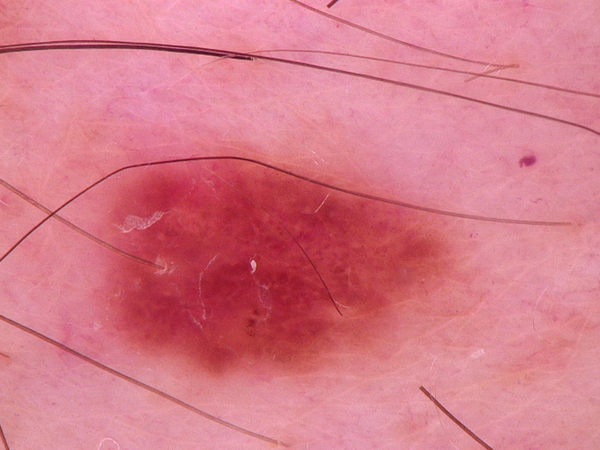

processed image:


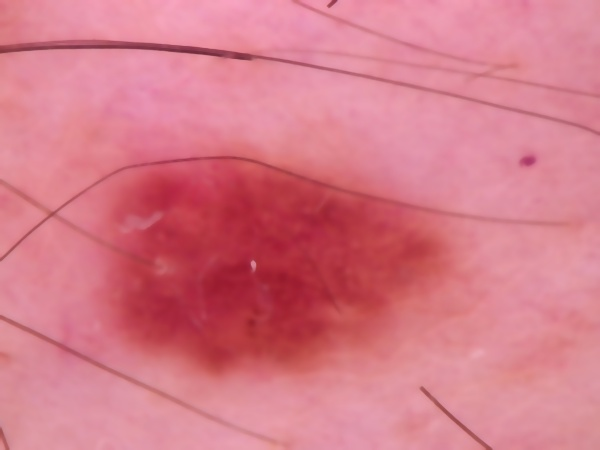

In [ ]:
input = '/content/ham10000_images_part_2/ISIC_0031388.jpg'
output = '/content/processed_image.jpg'

remove_noise(input, output)

print('original image:')
cv2_imshow(cv2.imread(input))

print('processed image:')
processed_image = cv2.imread(output)
cv2_imshow(processed_image)

array([[[224, 122, 133],
        [222, 126, 137],
        [222, 131, 138],
        ...,
        [224, 146, 162],
        [218, 140, 154],
        [219, 141, 157]],

       [[221, 119, 133],
        [225, 123, 137],
        [233, 133, 145],
        ...,
        [226, 144, 156],
        [217, 140, 148],
        [224, 141, 159]],

       [[217, 112, 127],
        [226, 119, 139],
        [232, 126, 146],
        ...,
        [219, 145, 158],
        [213, 140, 149],
        [220, 142, 156]],

       ...,

       [[219, 144, 148],
        [217, 147, 149],
        [217, 140, 146],
        ...,
        [208, 138, 138],
        [212, 139, 148],
        [214, 141, 148]],

       [[213, 142, 148],
        [213, 144, 149],
        [215, 144, 148],
        ...,
        [216, 141, 146],
        [214, 135, 141],
        [212, 140, 144]],

       [[217, 140, 146],
        [216, 144, 148],
        [214, 143, 147],
        ...,
        [213, 141, 145],
        [211, 136, 133],
        [211, 139, 143]]], dtype=uint8)
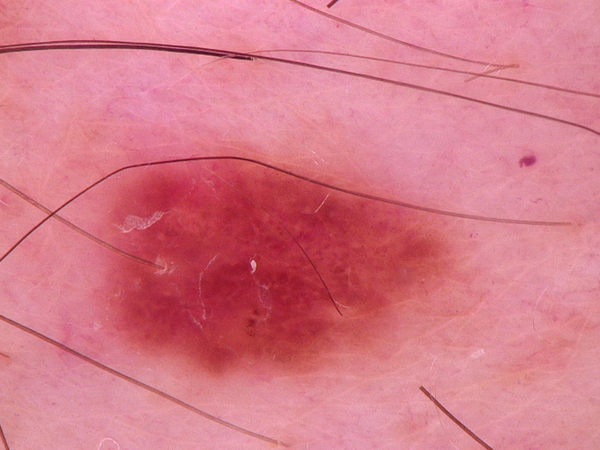

In [ ]:
plt.imread("/content/ham10000_images_part_2/ISIC_0031388.jpg")

## Duplicate Images Removal

In [ ]:
%pip install Pillow
%pip install imagededup
%pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
#function to remove duplicate images from the dataset -- NOT TESTED
#expects something like entireDataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Lab3_Gestures_Summer')
#returns cleaned up dataset with all duplicate images removed


import os
from PIL import Image
from imagededup.methods import PHash
import imagehash
from torchvision import datasets, transforms

def removeDuplicateImagesPIL(entireDataset):
    allDuplicateImages = set()
    allHashSet = set()
    cleanedDataset = []
    pilConvert = transforms.ToPILImage()

    for image, label in entireDataset:
        pil_image = pilConvert(image).convert('L')
        hash = imagehash.average_hash(pil_image)

        if hash in allHashSet:
            allDuplicateImages.add(pil_image)
        else:
            allHashSet.add(hash)
            cleanedDataset.append((image, label))

    return cleanedDataset


def removeDuplicateImagesImageDedup(entireDataset):
  pHasher = PHash()
  imagePaths = []
  for image, label in entireDataset:
    imagePaths.append(image)

  encodedImages = pHasher.encode_images(imagePaths)
  duplicateImages = pHasher.find_duplicates(encoding_map = encodedImages, min_similarity_threshold=0.9)
  duplicateImagePaths = set()
  for key, value in duplicateImages.items():
    for image in value:
      duplicateImagePaths.add(image)

  cleanedDataset = []
  for image, label in entireDataset:
    if image not in duplicateImagePaths:
      cleanedDataset.append((image, label))

  return cleanedDataset


In [ ]:
#remove duplicate images

all_data_cleaned = removeDuplicateImagesPIL(all_data)
all_data_cleaned = removeDuplicateImagesImageDedup(all_data)

KeyboardInterrupt: 

## Hair removal

In [ ]:
import cv2

# algorithm: dull razor technique, described here:
# https://link.springer.com/article/10.1007/s11042-022-13046-0
def hair_removal(img, kernal_size):
  """
  Removes hair from an image using a dull razor technique - applies
  a mask to the original image. Returns a new image with hair removed
  and does not modify the original image.
  """
  # convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # black hat filter
  kernal = cv2.getStructuringElement(1, (kernal_size, kernal_size))
  blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernal)

  # binary thresholding
  ret,mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)

  # apply mask to original image
  dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

  return dst

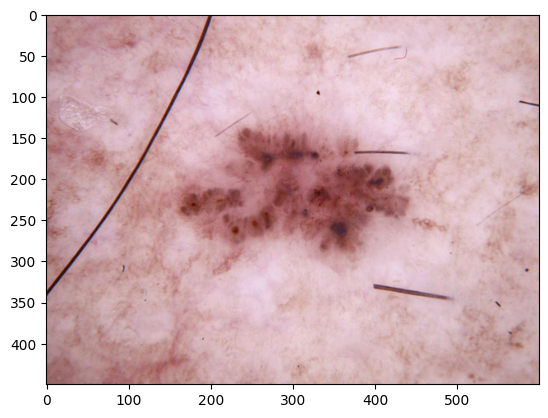

In [ ]:
img = plt.imread('/content/data/bcc/ISIC_0024403.jpg')
plt.imshow(img)

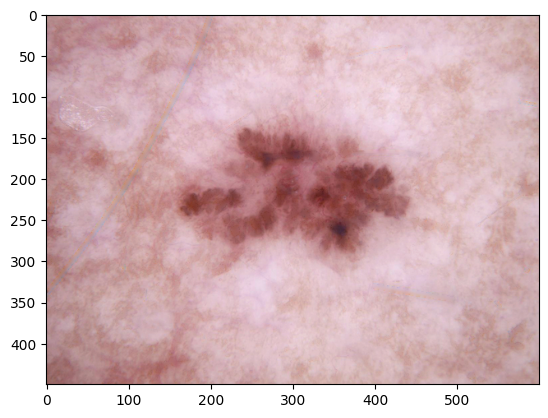

In [ ]:
new = hair_removal(img, 15)
plt.imshow(new)

# Data visualization

In [15]:
# navigate to the directory with the imported datasets
import os
proj_dir = '/content/data'
os.chdir(proj_dir)

if os.path.exists('.ipynb_checkpoints'):
    !rm -r .ipynb_checkpoints

# use transform to ensure that input image is 224x224 RGB () image as input
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(proj_dir, transform=transform)

In [16]:
# preview contents of all data
all_data

Dataset ImageFolder
    Number of datapoints: 2914
    Root location: /content/data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

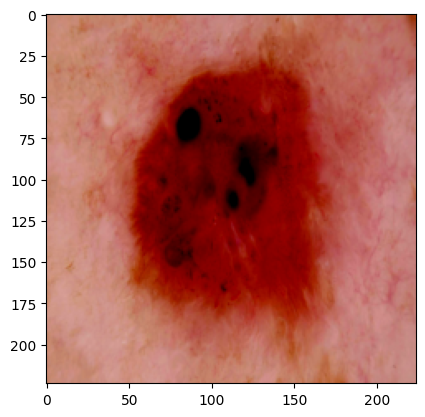

In [ ]:
# visualize a single image in the set
image_data = all_data[200][0] # torch.Tensor of shape [3, 224, 224]

# convert to numpy array
image_np = image_data.numpy()

# transpose for matplotlib
image_np = np.transpose(image_np, (1, 2, 0))

# show
plt.imshow(image_np)

In [18]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.2)

# remaining ~60% is left for training
train_size = len(all_data) - 2 * test_size

# randomly split the data into training, test and validation sets
train_data, val_data, test_data = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size])

In [ ]:
# visualize the training, validation and test sets

# Baseline model (SVM)

Things to add:
- ADAM
- exponential learning rate decay
- dropout
- weight decay

# Primary model (CNN)

In [19]:
len(test_data)
len(train_data)

1750

In [20]:
def get_model_name(trial, batch_size, learning_rate, epoch):
 path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(trial,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
 return path

In [44]:

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        #input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 16, 3)
        self.fc = nn.Linear(16, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(16*5*5, -1)
        x = self.fc(x)
        return x

In [22]:
use_cuda = True
import torch
import time
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

# pass thorugh data and not data loader to allow for variance in batch size
def train(model, data, val_data=None, trial_num=0, batch_size=64, lr=0.005, num_epochs=32):
    torch.manual_seed(1000)

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            # convert the labels to floating point type
            # labels = labels.float()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy
        if val_data != None:
            val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
            v_loss = criterion(out, labels)
            val_loss.append(float(v_loss)/batch_size)
        n += 1

        # Save checkpoint every 10 epochs
        if n % 10 == 0:
            model_path = get_model_name(trial_num, batch_size, lr, n)
            torch.save(model.state_dict(), model_path)
        # print("Epoch: ", epoch)
        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    if val_data != None:
        plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if val_data != None:
        plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [23]:
# a function to get the accuracy of a model on a dataset
def get_accuracy(model, data, batch_size):
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1,keepdim = True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
train(CNNClassifier(), train_data, val_data, trial_num=0, batch_size=128, lr=0.005, num_epochs=20)

Epoch 1: Train acc: 0.2702857142857143 | Validation acc: 0.2972508591065292
Epoch 2: Train acc: 0.2937142857142857 | Validation acc: 0.30412371134020616
Epoch 3: Train acc: 0.3457142857142857 | Validation acc: 0.30584192439862545
Epoch 4: Train acc: 0.3628571428571429 | Validation acc: 0.4054982817869416
Epoch 5: Train acc: 0.41485714285714287 | Validation acc: 0.422680412371134
Epoch 6: Train acc: 0.4765714285714286 | Validation acc: 0.4639175257731959
Epoch 7: Train acc: 0.5154285714285715 | Validation acc: 0.49140893470790376
Epoch 8: Train acc: 0.5045714285714286 | Validation acc: 0.46735395189003437


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
train(model, train_data, val_data, trial_num=0, batch_size=128, lr=0.05, num_epochs=1)

###[CBAM + BAM + ResNet]

CBAM from https://github.com/Jongchan/attention-module/blob/master/MODELS/cbam.py

In [24]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

BAM from https://github.com/Jongchan/attention-module/blob/master/MODELS/bam.py

In [25]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class ChannelGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, num_layers=1):
        super(ChannelGate, self).__init__()
        self.gate_c = nn.Sequential()
        self.gate_c.add_module( 'flatten', Flatten() )
        gate_channels = [gate_channel]
        gate_channels += [gate_channel // reduction_ratio] * num_layers
        gate_channels += [gate_channel]
        for i in range( len(gate_channels) - 2 ):
            self.gate_c.add_module( 'gate_c_fc_%d'%i, nn.Linear(gate_channels[i], gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_bn_%d'%(i+1), nn.BatchNorm1d(gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_relu_%d'%(i+1), nn.ReLU() )
        self.gate_c.add_module( 'gate_c_fc_final', nn.Linear(gate_channels[-2], gate_channels[-1]) )
    def forward(self, in_tensor):
        avg_pool = F.avg_pool2d( in_tensor, in_tensor.size(2), stride=in_tensor.size(2) )
        return self.gate_c( avg_pool ).unsqueeze(2).unsqueeze(3).expand_as(in_tensor)

class SpatialGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, dilation_conv_num=2, dilation_val=4):
        super(SpatialGate, self).__init__()
        self.gate_s = nn.Sequential()
        self.gate_s.add_module( 'gate_s_conv_reduce0', nn.Conv2d(gate_channel, gate_channel//reduction_ratio, kernel_size=1))
        self.gate_s.add_module( 'gate_s_bn_reduce0',	nn.BatchNorm2d(gate_channel//reduction_ratio) )
        self.gate_s.add_module( 'gate_s_relu_reduce0',nn.ReLU() )
        for i in range( dilation_conv_num ):
            self.gate_s.add_module( 'gate_s_conv_di_%d'%i, nn.Conv2d(gate_channel//reduction_ratio, gate_channel//reduction_ratio, kernel_size=3, \
						padding=dilation_val, dilation=dilation_val) )
            self.gate_s.add_module( 'gate_s_bn_di_%d'%i, nn.BatchNorm2d(gate_channel//reduction_ratio) )
            self.gate_s.add_module( 'gate_s_relu_di_%d'%i, nn.ReLU() )
        self.gate_s.add_module( 'gate_s_conv_final', nn.Conv2d(gate_channel//reduction_ratio, 1, kernel_size=1) )
    def forward(self, in_tensor):
        return self.gate_s( in_tensor ).expand_as(in_tensor)
class BAM(nn.Module):
    def __init__(self, gate_channel):
        super(BAM, self).__init__()
        self.channel_att = ChannelGate(gate_channel)
        self.spatial_att = SpatialGate(gate_channel)
    def forward(self,in_tensor):
        att = 1 + F.sigmoid( self.channel_att(in_tensor) * self.spatial_att(in_tensor) )
        return att * in_tensor

ResNet + CBAM, heavily referenced: https://github.com/Jongchan/attention-module/blob/master/MODELS/model_resnet.py

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        #self.fc = nn.Linear(512 * block.expansion, num_classes)

        """
        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0
        """

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        #if self.network_type == "ImageNet":
        #    x = self.avgpool(x)
        #else:
        #    x = F.avg_pool2d(x, 4)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)
        return x

def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

In [41]:
RNmodel = ResidualNet("ImageNet", 18, 4, "BAM")
CNNmodel = CNNClassifier();

Train [Resnet + cbam + bam] -> CNN

In [46]:
use_cuda = True
import torch
import time
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

# pass thorugh data and not data loader to allow for variance in batch size
def train(resnetModel, cnnModel, data, val_data=None, trial_num=0, batch_size=64, lr=0.005, num_epochs=32):
    torch.manual_seed(1000)

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(cnnModel.parameters(), lr, momentum=0.9)
    optimizer = optim.SGD(list(cnnModel.parameters()) + list(resnetModel.parameters()), lr, momentum=0.9)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #if use_cuda and torch.cuda.is_available():
            #    imgs = imgs.cuda()
            #    labels = labels.cuda()

            # convert the labels to floating point type
            # labels = labels.float()
            out = resnetModel(imgs)             # forward pass
            print("ResNet output shape ", out.shape)
            #print(out)
            #out = out.view(out.shape[0], -1)
            out = out.view(out.size(0), -1)
            out = cnnModel(out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy
        if val_data != None:
            val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
            v_loss = criterion(out, labels)
            val_loss.append(float(v_loss)/batch_size)
        n += 1

        # Save checkpoint every 10 epochs
        if n % 10 == 0:
            model_path = get_model_name(trial_num, batch_size, lr, n)
            torch.save(model.state_dict(), model_path)
        # print("Epoch: ", epoch)
        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    if val_data != None:
        plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if val_data != None:
        plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [1]:
train(RNmodel, CNNmodel, train_data, val_data, trial_num=0, batch_size=128, lr=0.05, num_epochs=1)

NameError: name 'train' is not defined